In [ ]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying file from Google Drive Shared folder to GCP Buckets for further analysis process. This's already done. No other action need. Just for reference

After mount the G-drive, /content/gdrive/ is your G-drive root folder, you can check at the left side bar(click the folder icon)

## GCP stuff for run in batch for <a name="preparation">preparation</a>

### Getting authorization for Colab to access your G-Drive. 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Getting authorization for Colab to access GCP bucket. 

"cmpe255-proj9455-a0bc92ffca54.json" is the key file to access the shared GCP bucket, please copy the file into your google drive root folder, and run the steps

In [ ]:
#put the key json file into google drive folder root
GOOGLE_APPLICATION_CREDENTIALS_PATH ="/content/gdrive/MyDrive/255/key-file/cmpe255-proj9455-a0bc92ffca54.json" 

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = GOOGLE_APPLICATION_CREDENTIALS_PATH
!gcloud auth activate-service-account --key-file={GOOGLE_APPLICATION_CREDENTIALS_PATH}

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
#create a project
project_id = 'cmpe255-proj9455'
#!gcloud -q config set project {project_id}

Activated service account credentials for: [cmpe255-proj9455@appspot.gserviceaccount.com]


Listing the directory in the bucket

In [ ]:
from google.cloud import storage
client=storage.Client(project=project_id)
buckets = client.list_buckets()

for bk in buckets:
  print(bk.name)

cmpe255-proj9455.appspot.com
cmpe255_bucket1
staging.cmpe255-proj9455.appspot.com


getting the bucket path for collection of datasets

In [ ]:
# change the values based on your GCP bucket structure 
bucket_id = 'cmpe255_bucket1'
folder_id = 'proj255data'  
print("bucket path: gs://"+bucket_id+"/"+folder_id+"/")

bucket path: gs://cmpe255_bucket1/proj255data/


Listing the datasets in the bucket

In [ ]:
# The name for the bucket, and list the datasets
bucket = client.get_bucket(bucket_id)
blobs = bucket.list_blobs()

def humanreadable(num):
  KB = 1024
  MB = KB*1024
  GB = MB*1024
  if num > GB:
    return "{0:4.2f} GB".format(num/GB)
  elif num > MB:
    return "{0:4.2f} MB".format(num/MB)
  elif num > KB:
    return "{0:4.2f} KB".format(num/KB)
  return num

n = 0
total=0
for bl in blobs:
  n+=1
  total+=bl.size
  print(bl.name+', '+humanreadable(bl.size))

if n is not 0:
  print(str(n)+' records, '+humanreadable(total))
else:
  print('Bucket empty, copying files from G-drive...')
  !gsutil ls gs://{bucket_id}/{folder_id}/ ; [ $? -eq 0 ] && echo Data files available || gsutil -m cp 'gdrive/MyDrive/CMPE 255 Datasets/*.csv' gs://{bucket_id}/{folder_id}/


proj255data/FoodData.csv, 11.17 KB
proj255data/PP_recipes.csv, 195.42 MB
proj255data/PP_users.csv, 12.93 MB
proj255data/RAW_interactions.csv, 333.25 MB
proj255data/RAW_recipes.csv, 280.88 MB
proj255data/interactions_test.csv, 510.48 KB
proj255data/interactions_train.csv, 26.94 MB
proj255data/interactions_validation.csv, 285.46 KB
8 records, 850.20 MB


installing and importing necessary package

In [ ]:
# gcsfs required by pd.read_csv accessing from bucket
try:
  import gcsfs
except ImportError:
  print("Module missing, installing it now ...")
  !pip install gcsfs
  import gcsfs

print(str(gcsfs) + ' imported')

<module 'gcsfs' from '/usr/local/lib/python3.7/dist-packages/gcsfs/__init__.py'> imported


## Load data section

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


Loading the datasets and assign to variable references

In [ ]:
print('Loading data ...')
data_path = 'gs://'+bucket_id+'/'+folder_id+'/'
df_food=pd.read_csv(data_path +'FoodData.csv')
df_precipes=pd.read_csv(data_path +'PP_recipes.csv')
df_users=pd.read_csv(data_path +'PP_users.csv')
df_rinteraction=pd.read_csv(data_path +'RAW_interactions.csv')
df_rrecipes=pd.read_csv(data_path +'RAW_recipes.csv')
df_itest=pd.read_csv(data_path +'interactions_test.csv')
df_itrain=pd.read_csv(data_path +'interactions_train.csv')
df_ivalidate=pd.read_csv(data_path +'interactions_validation.csv')
print('Data Ready')


Loading data ...
Data Ready


[Jump back GCP section to preparation](#preparation)

In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 13.8 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633988 sha256=bc14403c196a8d1a0ee25ce05a196260078382bec1cf41aed7c5501c1c407440
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

print('Loading data ...')
data_path = 'gs://'+bucket_id+'/'+folder_id+'/'
#//Load training data only
df_itrain=pd.read_csv(data_path +'interactions_train.csv')
print('Data Ready')


Loading data ...
Data Ready


In [ ]:
df_itrain

user_id  recipe_id        date  rating      u       i
0             2046       4684  2000-02-25     5.0  22095   44367
1             2046        517  2000-02-25     5.0  22095   87844
2             1773       7435  2000-03-13     5.0  24732  138181
3             1773        278  2000-03-13     4.0  24732   93054
4             2046       3431  2000-04-07     5.0  22095  101723
...            ...        ...         ...     ...    ...     ...
698896      926904     457971  2018-12-18     5.0  13681  141067
698897  2002312797      27208  2018-12-18     5.0  14897   99787
698898     1290903     131607  2018-12-18     5.0  11605   76163
698899      226867     363072  2018-12-18     5.0   3604   29101
698900  2000498330     314535  2018-12-19     5.0   2248   21514

[698901 rows x 6 columns]

In [ ]:
idx_r=df_itrain.index.values.tolist();
np.random.shuffle(idx_r)
# idx_r = idx_r[:15000]
idx_train = idx_r[:2*len(idx_r)//20]  #// reduce size of training data, otherwise colab will crash

data_train = df_itrain.iloc[idx_train]
data_train


user_id  recipe_id        date  rating      u       i
17012     37305      50376  2003-01-24     5.0    238  155126
626248    53002     127867  2012-06-01     0.0    899  122948
694184  1179225     154563  2017-05-20     3.0    503  126912
681687  1663024     119109  2014-11-15     5.0  15607  134474
59058    116854      88086  2004-08-26     5.0   1851     710
...         ...        ...         ...     ...    ...     ...
214605   194993     215903  2007-05-06     5.0   5943   96685
669611   222564     229457  2014-01-02     5.0    132  137435
483713  1383781      79944  2009-11-01     5.0   6764    1022
502574   230102      81908  2010-01-12     5.0   1034  175217
282634   291980       9494  2008-01-02     3.0   6068    6569

[69890 rows x 6 columns]

In [ ]:
from surprise import Dataset
from surprise import Reader

reader = Reader(rating_scale=(1, 5))

# Loads Pandas dataframe
data = Dataset.load_from_df(data_train[["user_id", "recipe_id", "rating"]], reader)


In [ ]:
data.df

user_id  recipe_id  rating
17012     37305      50376     5.0
626248    53002     127867     0.0
694184  1179225     154563     3.0
681687  1663024     119109     5.0
59058    116854      88086     5.0
...         ...        ...     ...
214605   194993     215903     5.0
669611   222564     229457     5.0
483713  1383781      79944     5.0
502574   230102      81908     5.0
282634   291980       9494     3.0

[69890 rows x 3 columns]

In [ ]:
from surprise import KNNWithMeans

# To use item-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": True,  # Compute  similarities between items or not
}
algo = KNNWithMeans(sim_options=sim_options)

trainingSet = data.build_full_trainset()

algo.fit(trainingSet)
#Computing the cosine similarity matrix...
#Done computing similarity matrix.
#<surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7f04fec56898>

user_id = 37305
recipe_id = 363072
prediction = algo.predict(user_id, recipe_id)
print("prediction.est=")
prediction.est

Computing the cosine similarity matrix...
Done computing similarity matrix.
prediction.est=


/usr/local/lib/python3.7/dist-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


4.363636363636363

In [ ]:
# select * from the rows that user_id = <user_id defined above>"
df_itrain.loc[df_itrain['user_id']==user_id]

user_id  recipe_id        date  rating    u       i
3616      37305       5284  2002-04-12     0.0  238    1924
3627      37305      17767  2002-04-12     4.0  238  129753
3813      37305       8701  2002-04-18     4.0  238   19634
4562      37305      27063  2002-05-13     5.0  238   90649
4805      37305       4332  2002-05-18     5.0  238   89084
...         ...        ...         ...     ...  ...     ...
568804    37305     175034  2011-01-08     0.0  238    6427
610178    37305     135294  2011-12-14     4.0  238   13230
610264    37305     142909  2011-12-15     5.0  238   83801
614114    37305     142363  2012-01-21     5.0  238   84884
696505    37305     184592  2017-12-27     5.0  238   16001

[490 rows x 6 columns]

# Testing new algorithms

## Load data

[Jump back GCP section to preparation](#preparation)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

print('Loading data ...')
data_path = 'gs://'+bucket_id+'/'+folder_id+'/'
#//Load necessary data only
df_rrecipes=pd.read_csv(data_path +'RAW_recipes.csv')
df_itrain=pd.read_csv(data_path +'interactions_train.csv')
print('Data Ready')

Loading data ...
Data Ready


#### (Skip) data that might not need for the section

In [ ]:
#//Load necessary data only,
# to load remove the # begin in next line
#df_food=pd.read_csv(data_path +'FoodData.csv')
print('Data Ready')

Data Ready


In [ ]:
#//Load necessary data only, 
# to load remove the # begin in next line
#df_precipes=pd.read_csv(data_path +'PP_recipes.csv')
print('Data Ready')

Data Ready


In [ ]:
#//Load necessary data only
# to load remove the # begin in next line
#df_users=pd.read_csv(data_path +'PP_users.csv')
print('Data Ready')

Data Ready


In [ ]:
#//Load necessary data only
# to load remove the # begin in next line
# df_rinteraction=pd.read_csv(data_path +'RAW_interactions.csv')
print('Data Ready')

Data Ready


In [ ]:
#//Load necessary data only
# to load remove the # begin in next line
#df_itest=pd.read_csv(data_path +'interactions_test.csv')
print('Data Ready')

Data Ready


In [ ]:
#//Load necessary data only
# to load remove the # begin in next line
#df_ivalidate=pd.read_csv(data_path +'interactions_validation.csv')
print('Data Ready')

Data Ready


In [ ]:
# get n pairs of key-value from a set
def getNkeyVpairs(aset, n):
  return {k: aset[k] for k in list(aset)[:n]}

## Clean up data 

In [ ]:
recipes = df_rrecipes
# rating = df_itrain
rating = df_rinteraction

In [ ]:
#Unique values in each dataframe
recipes.nunique()

name              230185
id                231637
minutes              888
contributor_id     27926
submitted           5090
tags              209115
nutrition         229318
n_steps               94
steps             231074
description       222668
ingredients       230475
n_ingredients         41
dtype: int64

In [ ]:
#Import the ratings csv file 
recipes = recipes.rename(columns={"id":"recipe_id"})

In [ ]:
# Show unique values in ratings dataframe
rating.nunique()

user_id       226570
recipe_id     231637
date            6396
rating             6
review       1125282
dtype: int64

In [ ]:
#Merge recipes and ratings dataframes for easier reference.
df = pd.merge(rating, recipes, on='recipe_id', how='left')
df.head()

user_id  recipe_id        date  rating  \
0    38094      40893  2003-02-17       4   
1  1293707      40893  2011-12-21       5   
2     8937      44394  2002-12-01       4   
3   126440      85009  2010-02-27       5   
4    57222      85009  2011-10-01       5   

                                              review  \
0  Great with a salad. Cooked on top of stove for...   
1  So simple, so delicious! Great for chilly fall...   
2  This worked very well and is EASY.  I used not...   
3  I made the Mexican topping and took it to bunk...   
4  Made the cheddar bacon topping, adding a sprin...   

                                   name  minutes  contributor_id   submitted  \
0  white bean   green chile pepper soup      495            1533  2002-09-21   
1  white bean   green chile pepper soup      495            1533  2002-09-21   
2      devilicious cookie cake delights       20           56824  2002-10-27   
3                 baked potato toppings       10           64342  2004-02-25   
4                 baked potato toppings       10           64342  2004-02-25   

                                                tags  \
0  ['weeknight', 'time-to-make', 'course', 'main-...   
1  ['weeknight', 'time-to-make', 'course', 'main-...   
2  ['30-minutes-or-less', 'time-to-make', 'course...   
3  ['15-minutes-or-less', 'time-to-make', 'course...   
4  ['15-minutes-or-less', 'time-to-make', 'course...   

                                           nutrition  n_steps  \
0           [204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]        4   
1           [204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]        4   
2           [132.3, 11.0, 39.0, 5.0, 4.0, 11.0, 5.0]        5   
3  [2786.2, 342.0, 134.0, 290.0, 161.0, 301.0, 42.0]        3   
4  [2786.2, 342.0, 134.0, 290.0, 161.0, 301.0, 42.0]        3   

                                               steps  \
0  ['combine beans , onion , chilies , 1 / 2 teas...   
1  ['combine beans , onion , chilies , 1 / 2 teas...   
2  ['blend together cake mix , oil and eggs', 'ad...   
3  ['pick whichever topping you want to use and c...   
4  ['pick whichever topping you want to use and c...   

                                         description  \
0                        easy soup for the crockpot.   
1                        easy soup for the crockpot.   
2                                                NaN   
3  these toppings sure makes a nice change from p...   
4  these toppings sure makes a nice change from p...   

                                         ingredients  n_ingredients  
0  ['great northern beans', 'yellow onion', 'dice...              9  
1  ['great northern beans', 'yellow onion', 'dice...              9  
2  ["devil's food cake mix", 'vegetable oil', 'eg...              4  
3  ['mayonnaise', 'salsa', 'cheddar cheese', 'ref...             13  
4  ['mayonnaise', 'salsa', 'cheddar cheese', 'ref...             13

In [ ]:
#Drop 'date' as this column is unnecessary
data = df.drop('date', axis=1)

In [ ]:
#Check sparsity of matrix
numratings = len(data['rating'])
numusers = len(data['user_id'].unique())
numitems = len(data['recipe_id'].unique())
sparse = 1 - (numratings / (numusers*numitems))
sparse

0.9999784237051572

In [ ]:
#Filter out users who have rated less than 200 movies 
data = data.groupby('user_id').filter(lambda x: len(x)>200)

In [ ]:
#Filter out recipes who have rated less than 10 movies 
data = data.groupby('recipe_id').filter(lambda x: len(x)>10)

In [ ]:
#Check sparsity of new matrix
numratings = len(data['rating'])
numusers = len(data['user_id'].unique())
numitems = len(data['recipe_id'].unique())
sparse = 1 - (numratings / (numusers*numitems))
sparse

0.9733815904805339

In [ ]:
#Check for NA values 
data.isna().sum()

user_id              0
recipe_id            0
rating               0
review               1
name                 0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
steps                0
description       1001
ingredients          0
n_ingredients        0
dtype: int64

In [ ]:
#Drop any NA values 
data.dropna(inplace=True)

In [ ]:
#See which recipe_id have the highest number of views
data['recipe_id'].value_counts()

27208     155
77397     131
68955     128
69173     127
28148     124
         ... 
14220      11
263081     11
109655     11
194466     11
457840     11
Name: recipe_id, Length: 4399, dtype: int64

In [ ]:
#See which users have provided the most ratings
data['user_id'].value_counts()

140132     1187
37449       739
383346      652
226863      572
176615      564
           ... 
236470       13
356127       12
1287956      11
381180       10
54716         9
Name: user_id, Length: 694, dtype: int64

In [ ]:
#View the distribution of ratings 
data['rating'].value_counts()

5    65356
4    12438
3     1986
0     1027
2      389
1      100
Name: rating, dtype: int64

In [ ]:
#View the distribution of submitted 
data['submitted'].value_counts()

2002-05-03    334
2003-06-05    328
2002-05-29    309
2002-04-22    294
2002-05-13    290
             ... 
2009-09-04     11
2009-07-16     11
2007-10-03     11
2003-11-17     11
2010-07-26     11
Name: submitted, Length: 1912, dtype: int64

In [ ]:
#Investigate the number of unique submitted 
data['submitted'].nunique()

1912

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


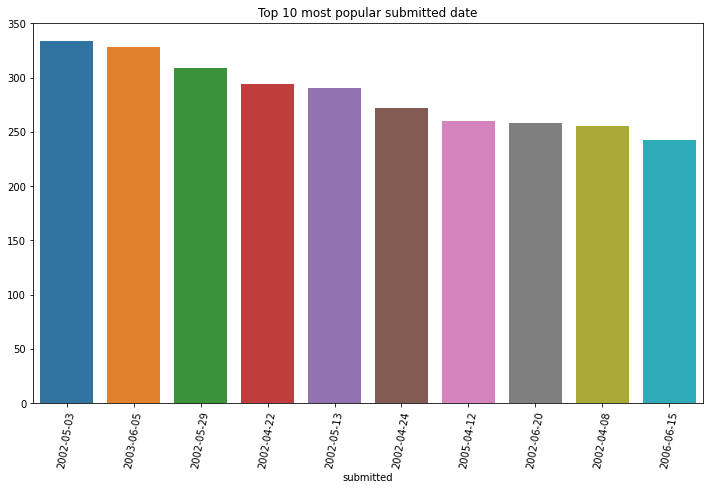

In [ ]:
#Top 10 with the most recipes submitted.
plt.figure(figsize=(12,7))
topsubmitted = data.groupby('submitted').size().sort_values(ascending=False).head(10)
sns.barplot(topsubmitted.index, topsubmitted.values)
plt.title('Top 10 most popular submitted date')
plt.xticks(rotation=80);

In [ ]:
#Print the average ratings of recipes 
data.groupby('name').mean()['rating'].sort_values(ascending=False)

name
jalapeno corn muffins with honey butter       5.000000
oven roasted asparagus with garlic            5.000000
parmesan lemon herb brown rice                5.000000
parmesan and basil orzo                       5.000000
parmesan acorn squash                         5.000000
                                                ...   
cottage cheese burgers                        3.583333
bacon and egg cups                            3.555556
simply delicious honey spiced carrots         3.454545
pasta with creamy red roasted pepper sauce    3.454545
boston market meatloaf by todd wilbur         3.307692
Name: rating, Length: 4397, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


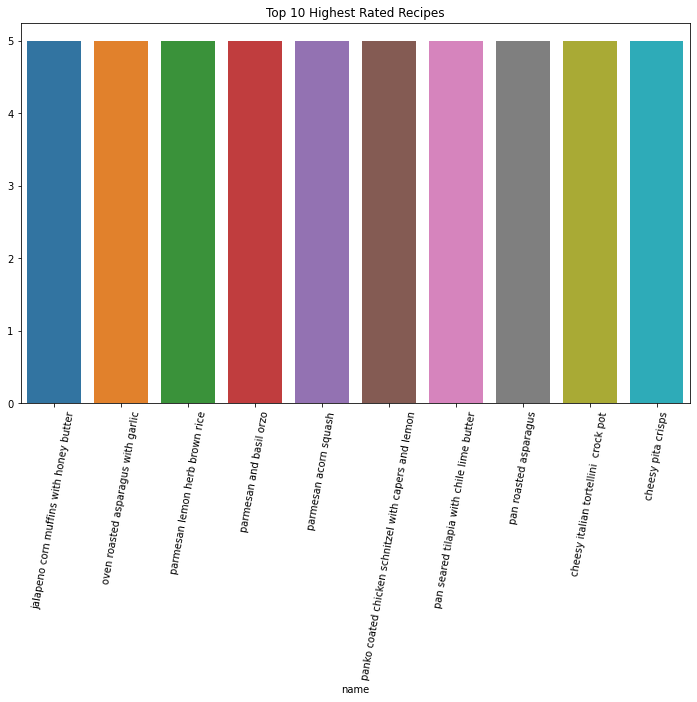

In [ ]:
#Plot the top 10 highest rated recipes
plt.figure(figsize=(12,7))
toprecipes = data.groupby('name').mean()['rating'].sort_values(ascending=False).head(10)
sns.barplot(toprecipes.index, toprecipes.values)
plt.title('Top 10 Highest Rated Recipes')
plt.xticks(rotation=80);

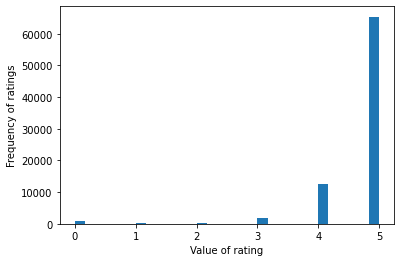

In [ ]:
#Plot a histogram of the frequency of certain rating values
plt.hist(data['rating'],bins=30)
plt.xlabel('Value of rating')
plt.ylabel('Frequency of ratings')
plt.show()

In [ ]:
# Look at how many times each recipe has been cooked
data.groupby('name').size().sort_values(ascending=False)

name
to die for crock pot roast                           155
kittencal s 5 minute cinnamon flop brunch cake       131
japanese mum s chicken                               128
kittencal s italian melt in your mouth meatballs     127
oven fried chicken chimichangas                      124
                                                    ... 
fake rotisserie chicken                               11
montreal rubbed chicken                               11
emily s sloppy joes                                   11
moroccan cinnamon coffee with orange flower water     11
fresh lemon mousse                                    11
Length: 4397, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

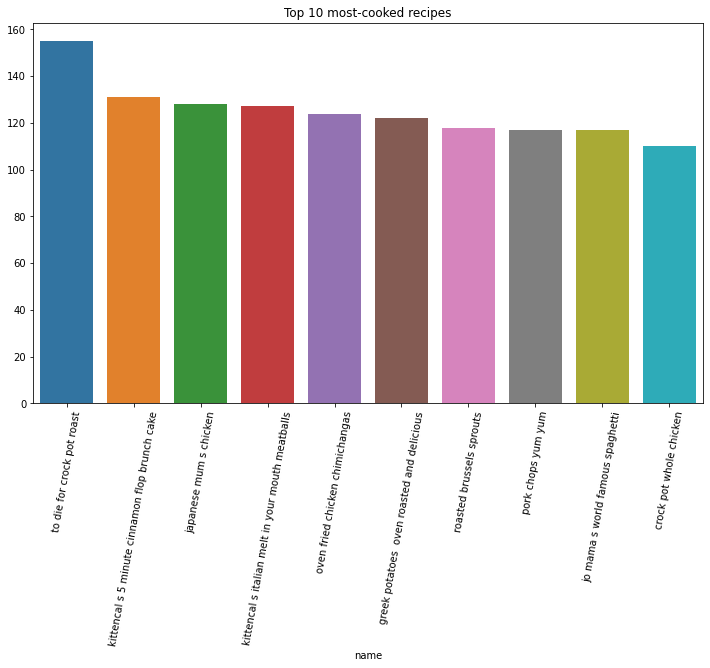

In [ ]:
#Plot the top 10 most cooked movies
plt.figure(figsize=(12,7))
toprecipes = data.groupby('name').size().sort_values(ascending=False).head(10)
sns.barplot(toprecipes.index, toprecipes.values)
plt.title('Top 10 most-cooked recipes')
plt.xticks(rotation=80)

In [ ]:
#checking the column name
data.columns

Index(['user_id', 'recipe_id', 'rating', 'review', 'name', 'minutes',
       'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps',
       'description', 'ingredients', 'n_ingredients'],
      dtype='object')

In [ ]:
data.head(2)

user_id  recipe_id  rating  \
440   424680     426090       5   
441   527886     426090       3   

                                                review  \
440  Really enjoyed working with the mustard seeds ...   
441  Very mild. I would double the ginger and coria...   

                         name  minutes  contributor_id   submitted  \
440  indian style green beans       33          135470  2010-05-17   
441  indian style green beans       33          135470  2010-05-17   

                                                  tags  \
440  ['60-minutes-or-less', 'time-to-make', 'course...   
441  ['60-minutes-or-less', 'time-to-make', 'course...   

                                 nutrition  n_steps  \
440  [58.6, 4.0, 15.0, 8.0, 3.0, 1.0, 2.0]        4   
441  [58.6, 4.0, 15.0, 8.0, 3.0, 1.0, 2.0]        4   

                                                 steps  \
440  ['heat 1 / 2-1 tbls oil in large skillet or wo...   
441  ['heat 1 / 2-1 tbls oil in large skillet or wo...   

                                           description  \
440  this is kid friendly, so mildly spiced. from  ...   
441  this is kid friendly, so mildly spiced. from  ...   

                                           ingredients  n_ingredients  
440  ['green beans', 'oil', 'mustard seeds', 'onion...              9  
441  ['green beans', 'oil', 'mustard seeds', 'onion...              9

In [ ]:
import json

# cleanup function for cleaning up the string before handle w/ json
def ingredstr2json(i):    
  x = i.replace("\"","\\\"") # replace sth like 9" to 9\"
  x = x.replace("['", "[\"") # ['  -> ["
  x = x.replace("[\\\"","[\"") # [\" -> ["
  x = x.replace("']", "\"]")   # ']  -> "]
  x = x.replace("\\\"]", "\"]") # \"] -> "]
  x = x.replace("', ", "\", ")  # ',_  ->  ",_  (_ is white space)   
  x = x.replace(", '", ", \"")   #  ,_' -> ,_" 
  x = x.replace(" \\\"", " \"") # _\" -> _"
  x = x.replace("\\\",", "\",") # \", -> ",
  try:
    res = json.loads(x)
  except: # display message for debug
    print("Err <<< {}".format(i)) 
    print("Err ||| {}".format(x))
  return res

#Creat ingredients labels
ingredlabels = set()
for i in data['ingredients']:
  res = ingredstr2json(i)
  ingredlabels = ingredlabels.union(res)

In [ ]:
# get the first 10 labels
list(ingredlabels)[:10]

['boneless beef top sirloin steaks',
 'cooked short-grain white rice',
 'seasoning salt',
 "m&m'",
 'v8 vegetable juice',
 'louisiana hot sauce',
 'cardamom powder',
 'sugar free 7-up',
 'cooking sherry',
 'low-fat plain yogurt']

In [ ]:
#Create function that counts how many recipes there are of each label 
def labelscounts(df, col, labels):
  count = dict()
  for i in labels: count[i] = 0
  for value in df[col]:
    if type(value) is not str and pd.isnull(value) : continue
    res = ingredstr2json(value)
    for i in res:
      if pd.notnull(i): count[i] += 1
  return count


In [ ]:
#Apply the labelscounts formula to dataset 
ingred_count = labelscounts(data, 'ingredients', ingredlabels)

In [ ]:
# print the ingreds and their counts, first 10 items
# {k: ingred_count[k] for k in list(ingred_count)[:10]}
getNkeyVpairs(ingred_count, 10)

{'boneless beef top sirloin steaks': 19,
 'cooked short-grain white rice': 25,
 'seasoning salt': 2329,
 "m&m'": 134,
 'v8 vegetable juice': 26,
 'louisiana hot sauce': 50,
 'cardamom powder': 17,
 'sugar free 7-up': 12,
 'cooking sherry': 38,
 'low-fat plain yogurt': 49}

In [ ]:
#Sort the DataFrame
ingreds = pd.DataFrame(list(ingred_count.items()), columns = ['ingredients', 'frequency'])

In [ ]:
ingreds = ingreds.sort_values(by=['frequency'], ascending=False)

In [ ]:
ingreds.head()

ingredients  frequency
765         salt      33343
381       butter      21610
2317       sugar      14461
1288   olive oil      12444
1320       onion      12408

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


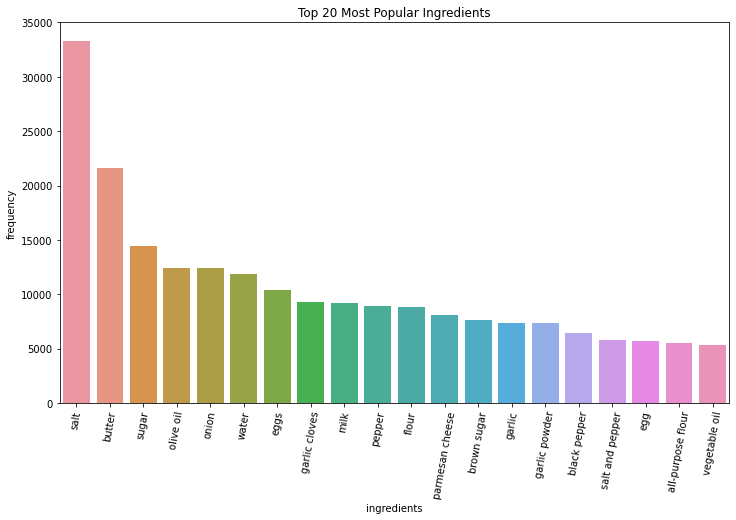

In [ ]:
#Plot the top most cooked recipes ingredients
plt.figure(figsize=(12,7))
n = 20
plotingreds = ingreds.head(n)
sns.barplot(plotingreds['ingredients'], plotingreds['frequency'])
plt.title('Top {} Most Popular Ingredients'.format(n))
plt.xticks(rotation=80);

In [ ]:
data.head(3)

user_id  recipe_id  rating  \
440   424680     426090       5   
441   527886     426090       3   
442   383346     426090       5   

                                                review  \
440  Really enjoyed working with the mustard seeds ...   
441  Very mild. I would double the ginger and coria...   
442  I used 2 tablespoon of canola oil.  And I used...   

                         name  minutes  contributor_id   submitted  \
440  indian style green beans       33          135470  2010-05-17   
441  indian style green beans       33          135470  2010-05-17   
442  indian style green beans       33          135470  2010-05-17   

                                                  tags  \
440  ['60-minutes-or-less', 'time-to-make', 'course...   
441  ['60-minutes-or-less', 'time-to-make', 'course...   
442  ['60-minutes-or-less', 'time-to-make', 'course...   

                                 nutrition  n_steps  \
440  [58.6, 4.0, 15.0, 8.0, 3.0, 1.0, 2.0]        4   
441  [58.6, 4.0, 15.0, 8.0, 3.0, 1.0, 2.0]        4   
442  [58.6, 4.0, 15.0, 8.0, 3.0, 1.0, 2.0]        4   

                                                 steps  \
440  ['heat 1 / 2-1 tbls oil in large skillet or wo...   
441  ['heat 1 / 2-1 tbls oil in large skillet or wo...   
442  ['heat 1 / 2-1 tbls oil in large skillet or wo...   

                                           description  \
440  this is kid friendly, so mildly spiced. from  ...   
441  this is kid friendly, so mildly spiced. from  ...   
442  this is kid friendly, so mildly spiced. from  ...   

                                           ingredients  n_ingredients  
440  ['green beans', 'oil', 'mustard seeds', 'onion...              9  
441  ['green beans', 'oil', 'mustard seeds', 'onion...              9  
442  ['green beans', 'oil', 'mustard seeds', 'onion...              9

In [ ]:
#Create columns for each ingredients to indicate True or False
for ingred in ingredlabels:
  data[ingred] = data['ingredients'].apply(lambda x: ingred in x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#Boolean values for each ingredients across every recipe in the data frame.
pd.set_option('max_columns', None)
data.head(5)

user_id  recipe_id  rating  \
440   424680     426090       5   
441   527886     426090       3   
442   383346     426090       5   
443   107135     426090       5   
444   895132     426090       5   

                                                review  \
440  Really enjoyed working with the mustard seeds ...   
441  Very mild. I would double the ginger and coria...   
442  I used 2 tablespoon of canola oil.  And I used...   
443  ok i used canned beans  cooked carrtos 1st . c...   
444  I had to use sweet potato instead of the carro...   

                         name  minutes  contributor_id   submitted  \
440  indian style green beans       33          135470  2010-05-17   
441  indian style green beans       33          135470  2010-05-17   
442  indian style green beans       33          135470  2010-05-17   
443  indian style green beans       33          135470  2010-05-17   
444  indian style green beans       33          135470  2010-05-17   

                                                  tags  \
440  ['60-minutes-or-less', 'time-to-make', 'course...   
441  ['60-minutes-or-less', 'time-to-make', 'course...   
442  ['60-minutes-or-less', 'time-to-make', 'course...   
443  ['60-minutes-or-less', 'time-to-make', 'course...   
444  ['60-minutes-or-less', 'time-to-make', 'course...   

                                 nutrition  n_steps  \
440  [58.6, 4.0, 15.0, 8.0, 3.0, 1.0, 2.0]        4   
441  [58.6, 4.0, 15.0, 8.0, 3.0, 1.0, 2.0]        4   
442  [58.6, 4.0, 15.0, 8.0, 3.0, 1.0, 2.0]        4   
443  [58.6, 4.0, 15.0, 8.0, 3.0, 1.0, 2.0]        4   
444  [58.6, 4.0, 15.0, 8.0, 3.0, 1.0, 2.0]        4   

                                                 steps  \
440  ['heat 1 / 2-1 tbls oil in large skillet or wo...   
441  ['heat 1 / 2-1 tbls oil in large skillet or wo...   
442  ['heat 1 / 2-1 tbls oil in large skillet or wo...   
443  ['heat 1 / 2-1 tbls oil in large skillet or wo...   
444  ['heat 1 / 2-1 tbls oil in large skillet or wo...   

                                           description  \
440  this is kid friendly, so mildly spiced. from  ...   
441  this is kid friendly, so mildly spiced. from  ...   
442  this is kid friendly, so mildly spiced. from  ...   
443  this is kid friendly, so mildly spiced. from  ...   
444  this is kid friendly, so mildly spiced. from  ...   

                                           ingredients  n_ingredients  \
440  ['green beans', 'oil', 'mustard seeds', 'onion...              9   
441  ['green beans', 'oil', 'mustard seeds', 'onion...              9   
442  ['green beans', 'oil', 'mustard seeds', 'onion...              9   
443  ['green beans', 'oil', 'mustard seeds', 'onion...              9   
444  ['green beans', 'oil', 'mustard seeds', 'onion...              9   

     boneless beef top sirloin steaks  cooked short-grain white rice  \
440                             False                          False   
441                             False                          False   
442                             False                          False   
443                             False                          False   
444                             False                          False   

     seasoning salt   m&m'  v8 vegetable juice  louisiana hot sauce  \
440           False  False               False                False   
441           False  False               False                False   
442           False  False               False                False   
443           False  False               False                False   
444           False  False               False                False   

     cardamom powder  sugar free 7-up  cooking sherry  low-fat plain yogurt  \
440            False            False           False                 False   
441            False            False           False                 False   
442            False            False           False                 False   
443            False           

In [ ]:
data.columns

Index(['user_id', 'recipe_id', 'rating', 'review', 'name', 'minutes',
       'contributor_id', 'submitted', 'tags', 'nutrition',
       ...
       'frozen cooked shrimp', 'double cream', 'vanilla flavoring',
       'low-fat mayonnaise', 'steak sauce',
       'nestle semi-sweet and white chocolate swirled chocolate morsels',
       'chive & onion cream cheese', 'tuna steaks', 'coriander',
       'picante sauce'],
      dtype='object', length=3033)

In [ ]:
#Create a logical matrix now that the ingredients have been parsed. 
# and remove unnecessary columns
# matrix = data.drop(['user_id', 'recipe_id', 'rating', 'u', 'i', 'minutes',
#        'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps',
#        'description', 'ingredients', 'n_ingredients'], axis=1)
matrix = data.drop(['user_id', 'recipe_id', 'rating', 
                    # 'u', 'i', 
                    'minutes',
       'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps',
       'description', 'ingredients', 'n_ingredients'], axis=1)
matrix.head(5)

review  \
440  Really enjoyed working with the mustard seeds ...   
441  Very mild. I would double the ginger and coria...   
442  I used 2 tablespoon of canola oil.  And I used...   
443  ok i used canned beans  cooked carrtos 1st . c...   
444  I had to use sweet potato instead of the carro...   

                         name  boneless beef top sirloin steaks  \
440  indian style green beans                             False   
441  indian style green beans                             False   
442  indian style green beans                             False   
443  indian style green beans                             False   
444  indian style green beans                             False   

     cooked short-grain white rice  seasoning salt   m&m'  v8 vegetable juice  \
440                          False           False  False               False   
441                          False           False  False               False   
442                          False           False  False               False   
443                          False           False  False               False   
444                          False           False  False               False   

     louisiana hot sauce  cardamom powder  sugar free 7-up  cooking sherry  \
440                False            False            False           False   
441                False            False            False           False   
442                False            False            False           False   
443                False            False            False           False   
444                False            False            False           False   

     low-fat plain yogurt  reduced sodium soy sauce  salad greens  \
440                 False                     False         False   
441                 False                     False         False   
442                 False                     False         False   
443                 False                     False         False   
444                 False                     False         False   

     oreo double stuff cookies  cream cheese  dried shredded coconut  \
440                      False         False                   False   
441                      False         False                   False   
442                      False         False                   False   
443                      False         False                   False   
444                      False         False                   False   

     hamburger meat  fresh white breadcrumbs  albacore tuna in water  \
440           False                    False                   False   
441           False                    False                   False   
442           False                    False                   False   
443           False                    False                   False   
444           False                    False                   False   

     lime zest  white chocolate chips  leafy greens  ham hock  melon liqueur  \
440      False                  False         False     False          False   
441      False                  False         False     False          False   
442      False                  False         False     False          False   
443      False                  False         False     False          False   
444      False                  False         False     False          False   

     white bread  garlic pepper seasoning  fresh lemon rind  frangelico  \
440        False                    False             False       False   
441        False                    False             False       False   
442        False                    False             False       False   
443        False                    False             False       False   
444        False                    False             False       False   

     green beans  cream cheese with chives  reduced-sodium chicken broth  \
440         True                     False         

In [ ]:
ing = 'baking potato'
x = matrix[(matrix[ing]==True)]
x

review  \
15979    These are fabulous! The mashed potato inside a...   
15981    I made these tonight for a special birthday di...   
15982    Excellent flavor!  I didn't change a thing exc...   
15983    This recipe  is soooooo good! It makes a reall...   
15984    These were wonderful! Nice and soft inside and...   
...                                                    ...   
1122532  Great way to do dinner!  Made as directed and ...   
1122533  I made these exactly as written and they made ...   
1122557  Yummy potatoes. I only made 2 servings this ti...   
1122558  OH WHAT HEAVEN!!!  Made the full batch for DH ...   
1122559  These were scrumptious!  I only used a 1/2 lb ...   

                          name  boneless beef top sirloin steaks  \
15979     twice baked potatoes                             False   
15981     twice baked potatoes                             False   
15982     twice baked potatoes                             False   
15983     twice baked potatoes                             False   
15984     twice baked potatoes                             False   
...                        ...                               ...   
1122532  beef stuffed potatoes                             False   
1122533  beef stuffed potatoes                             False   
1122557  beef stuffed potatoes                             False   
1122558  beef stuffed potatoes                             False   
1122559  beef stuffed potatoes                             False   

         cooked short-grain white rice  seasoning salt   m&m'  \
15979                            False           False  False   
15981                            False           False  False   
15982                            False           False  False   
15983                            False           False  False   
15984                            False           False  False   
...                                ...             ...    ...   
1122532                          False           False  False   
1122533                          False           False  False   
1122557                          False           False  False   
1122558                          False           False  False   
1122559                          False           False  False   

         v8 vegetable juice  louisiana hot sauce  cardamom powder  \
15979                 False                False            False   
15981                 False                False            False   
15982                 False                False            False   
15983                 False                False            False   
15984                 False                False            False   
...                     ...                  ...              ...   
1122532               False                False            False   
1122533               False                False            False   
1122557               False                False            False   
1122558               False                False            False   
1122559               False                False            False   

         sugar free 7-up  cooking sherry  low-fat plain yogurt  \
15979              False           False                 False   
15981              False           False                 False   
15982              False           False                 False   
15983              False           False                 False   
15984              False           False                 False   
...                  ...             ...                   ...   
1122532            False           False                 False   
1122533            False           False                 False   
1122557            False           False                 False   
1122558            False           False                 False   
1122559            False           False                 False   

         reduced sodium soy sauce  salad greens  oreo double stuff cookies  \
15979    

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


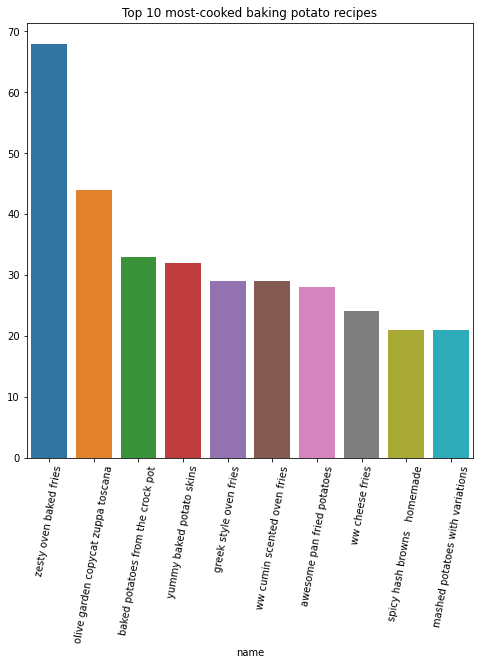

In [ ]:
plt.figure(figsize=(8,8))
toprecipes = x.groupby('name').size().sort_values(ascending=False).head(10)
sns.barplot(toprecipes.index, toprecipes.values)
plt.title('Top 10 most-cooked '+ing+' recipes')
plt.xticks(rotation=80);

In [ ]:
#Looking at which recipes are most popular in the ingredients, lets say 'boneless pork loin'
bonelessporkloin = data[(data['boneless pork loin']==True)]
bonelessporkloin.head(5)

user_id  recipe_id  rating  \
20137   174991     243405       5   
20138    67656     243405       5   
20139   481092     243405       4   
20140    89831     243405       5   
20141   199792     243405       5   

                                                  review  \
20137  Wow, the taste buds are jumping!  I grilled th...   
20138  The was superb in most every way; clear direct...   
20139  Great chops.  The dijon and balsamic may have ...   
20140  This had a wonderful combination of flavors, I...   
20141  I absolutely loved everything about this dish ...   

                           name  minutes  contributor_id   submitted  \
20137  mediterranean pork chops       30          382071  2007-07-30   
20138  mediterranean pork chops       30          382071  2007-07-30   
20139  mediterranean pork chops       30          382071  2007-07-30   
20140  mediterranean pork chops       30          382071  2007-07-30   
20141  mediterranean pork chops       30          382071  2007-07-30   

                                                    tags  \
20137  ['30-minutes-or-less', 'time-to-make', 'course...   
20138  ['30-minutes-or-less', 'time-to-make', 'course...   
20139  ['30-minutes-or-less', 'time-to-make', 'course...   
20140  ['30-minutes-or-less', 'time-to-make', 'course...   
20141  ['30-minutes-or-less', 'time-to-make', 'course...   

                                        nutrition  n_steps  \
20137  [292.1, 17.0, 62.0, 20.0, 52.0, 16.0, 7.0]       10   
20138  [292.1, 17.0, 62.0, 20.0, 52.0, 16.0, 7.0]       10   
20139  [292.1, 17.0, 62.0, 20.0, 52.0, 16.0, 7.0]       10   
20140  [292.1, 17.0, 62.0, 20.0, 52.0, 16.0, 7.0]       10   
20141  [292.1, 17.0, 62.0, 20.0, 52.0, 16.0, 7.0]       10   

                                                   steps  \
20137  ['coat the pork chops with spray oil and then ...   
20138  ['coat the pork chops with spray oil and then ...   
20139  ['coat the pork chops with spray oil and then ...   
20140  ['coat the pork chops with spray oil and then ...   
20141  ['coat the pork chops with spray oil and then ...   

                                             description  \
20137  the rsc#10 contest ingredients inspired this t...   
20138  the rsc#10 contest ingredients inspired this t...   
20139  the rsc#10 contest ingredients inspired this t...   
20140  the rsc#10 contest ingredients inspired this t...   
20141  the rsc#10 contest ingredients inspired this t...   

                                             ingredients  n_ingredients  \
20137  ['boneless pork loin chop', 'cooking spray', '...             18   
20138  ['boneless pork loin chop', 'cooking spray', '...             18   
20139  ['boneless pork loin chop', 'cooking spray', '...             18   
20140  ['boneless pork loin chop', 'cooking spray', '...             18   
20141  ['boneless pork loin chop', 'cooking spray', '...             18   

       boneless beef top sirloin steaks  cooked short-grain white rice  \
20137                             False                          False   
20138                             False                          False   
20139                             False                          False   
20140                             False                          False   
20141                             False                          False   

       seasoning salt   m&m'  v8 vegetable juice  louisiana hot sauce  \
20137           False  False               False                False   
20138           False  False               False                False   
20139           False  False               False                False   
20140           False  False               False                False   
20141           False  False               False                False   

       cardamom powder  sugar free 7-up  cooking sherry  low-fat plain yogurt  \
20137            False            False           False                 False   
20138            False            Fal

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

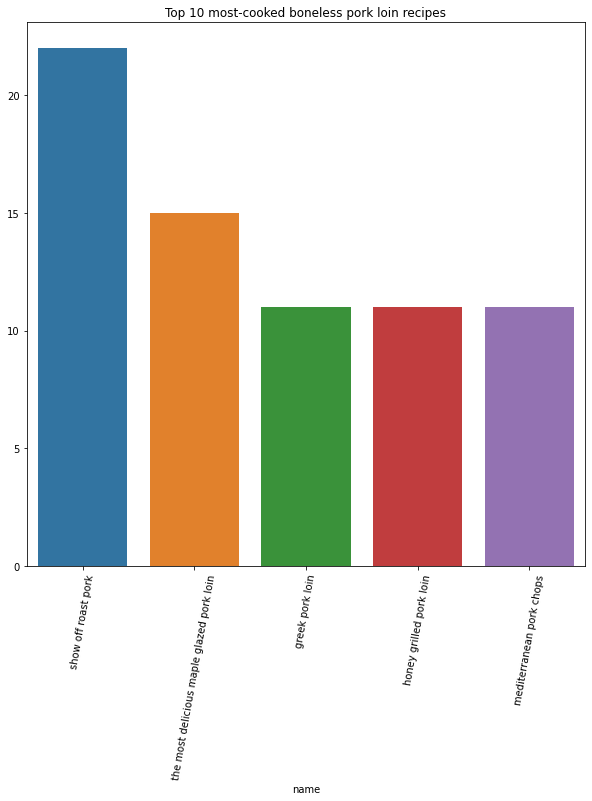

In [ ]:
#Plot the top 10 most-cooked boneless pork loin recipes
plt.figure(figsize=(10,10))
toprecipes = bonelessporkloin.groupby('name').size().sort_values(ascending=False).head(10)
sns.barplot(toprecipes.index, toprecipes.values)
plt.title('Top 10 most-cooked boneless pork loin recipes')
plt.xticks(rotation=80)

In [ ]:
#export the cleaned resulting data to a csv file
data.to_csv('mycleaneddata')

## Surprise

In [ ]:
!pip3 install -q scikit-surprise

     |████████████████████████████████| 11.8 MB 5.3 MB/s 


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import os

In [ ]:
#Import data into a DataFrame
#Option1: use our previous data
df = pd.read_csv('mycleaneddata', index_col=False)
#option2: reload the ratings.csv
# dataset_path='path-to-csv'
# ratings_file_path = os.path.join(dataset_path, 'iTrain.csv')
# df = pd.read_csv(ratings_file_path)


In [ ]:
#drop unnecessary columns 
df_simple = df[['user_id', 'recipe_id', 'rating']]

In [ ]:
df_simple.head(10)

user_id  recipe_id  rating
0   424680     426090       5
1   527886     426090       3
2   383346     426090       5
3   107135     426090       5
4   895132     426090       5
5   844554     426090       5
6   143721     426090       5
7   166642     426090       5
8   690623     426090       5
9   227978     426090       5

In [ ]:
df_simple.shape

(81296, 3)

In [ ]:
data = df_simple['rating'].value_counts().sort_index(ascending=False)

In [ ]:
data

5    65356
4    12438
3     1986
2      389
1      100
0     1027
Name: rating, dtype: int64

In [ ]:
data.values

array([65356, 12438,  1986,   389,   100,  1027])

In [ ]:
df_simple.shape[0]

81296

In [ ]:
from surprise import Dataset, Reader
#Instansiate reader and data 
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_simple, reader) 

In [ ]:
from surprise.model_selection import train_test_split
#Train test split with test sizre of 20% 
trainset, testset = train_test_split(data, test_size=.2)

In [ ]:
# Print number of uses and items for the trainset 
print('Number of users in train set : ', trainset.n_users, '\n')
print('Number of items in train set : ', trainset.n_items, '\n')

Number of users in train set :  694 

Number of items in train set :  4399 



###Baseline Model

In [ ]:
from surprise.prediction_algorithms import KNNBaseline
#Instansiate a baseline model using KNNBaseline 
baseline = KNNBaseline(random_state=42)
#Fit model on the trainset 
baseline.fit(trainset)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
#Predict on the test set 
baselinepreds = baseline.test(testset)

In [ ]:
from surprise import accuracy
#Check RMSE and MAE results 
accuracy.rmse(baselinepreds)
accuracy.mae(baselinepreds)

RMSE: 0.7276
MAE:  0.3913


0.391283312097174

### Multiple Models


In [ ]:
from surprise.model_selection import cross_validate
#https://surprise.readthedocs.io/en/stable/knn_inspired.html#
from surprise import KNNBasic 
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
#https://surprise.readthedocs.io/en/stable/matrix_factorization.html
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

In [ ]:
benchmark = []
# Iterate over all algorithms

algorithms = [SVD(), SVDpp(), NMF(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore()]

print("algorithms: ")
for al in algorithms:
  print(al)
print('\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    # results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")

print ('\n\tDONE\n')

algorithms: 



Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f8b2cc0a0d0>
Done:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f8b2cc0a0d0> 


Starting:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7f8b2c74d650>
Done:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7f8b2c74d650> 


Starting:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7f8b2c74d150>
Done:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7f8b2c74d150> 


Starting:  <surprise.prediction_algorithms.knns.KNNBaseline object at 0x7f8b2c74df90>
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Done:  <surprise.pred

In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

test_rmse    fit_time  test_time
Algorithm                                      
SVD             0.710672    8.641181   0.649755
SVDpp           0.711553  111.502235   5.437389
KNNBaseline     0.725297    0.366575   1.206286
KNNWithMeans    0.726068    0.108588   0.894666
KNNWithZScore   0.739034    0.177733   0.987215
KNNBasic        0.762552    0.085104   0.973437
NMF             0.811596    4.413515   0.303633

In [ ]:
param_grid = {
    "n_epochs": [10, 20],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.02]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], refit=True, cv=5)

gs.fit(data)

training_parameters = gs.best_params["rmse"]

print("BEST RMSE: \t", gs.best_score["rmse"])
print("BEST MAE: \t", gs.best_score["mae"])
print("BEST params: \t", gs.best_params["rmse"])

BEST RMSE: 	 0.7050385353341017
BEST MAE: 	 0.3892146115332327
BEST params: 	 {'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.02}


## Neural Network Recommendation

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

### Data Preparation

prepare

In [ ]:
# ratings_file = movielens_dir / "ratings.csv"
# df = pd.read_csv(ratings_file)

In [ ]:
df.head(3)

Unnamed: 0  user_id  recipe_id  rating  \
0         440   424680     426090       5   
1         441   527886     426090       3   
2         442   383346     426090       5   

                                              review  \
0  Really enjoyed working with the mustard seeds ...   
1  Very mild. I would double the ginger and coria...   
2  I used 2 tablespoon of canola oil.  And I used...   

                       name  minutes  contributor_id   submitted  \
0  indian style green beans       33          135470  2010-05-17   
1  indian style green beans       33          135470  2010-05-17   
2  indian style green beans       33          135470  2010-05-17   

                                                tags  \
0  ['60-minutes-or-less', 'time-to-make', 'course...   
1  ['60-minutes-or-less', 'time-to-make', 'course...   
2  ['60-minutes-or-less', 'time-to-make', 'course...   

                               nutrition  n_steps  \
0  [58.6, 4.0, 15.0, 8.0, 3.0, 1.0, 2.0]        4   
1  [58.6, 4.0, 15.0, 8.0, 3.0, 1.0, 2.0]        4   
2  [58.6, 4.0, 15.0, 8.0, 3.0, 1.0, 2.0]        4   

                                               steps  \
0  ['heat 1 / 2-1 tbls oil in large skillet or wo...   
1  ['heat 1 / 2-1 tbls oil in large skillet or wo...   
2  ['heat 1 / 2-1 tbls oil in large skillet or wo...   

                                         description  \
0  this is kid friendly, so mildly spiced. from  ...   
1  this is kid friendly, so mildly spiced. from  ...   
2  this is kid friendly, so mildly spiced. from  ...   

                                         ingredients  n_ingredients  \
0  ['green beans', 'oil', 'mustard seeds', 'onion...              9   
1  ['green beans', 'oil', 'mustard seeds', 'onion...              9   
2  ['green beans', 'oil', 'mustard seeds', 'onion...              9   

   boneless beef top sirloin steaks  cooked short-grain white rice  \
0                             False                          False   
1                             False                          False   
2                             False                          False   

   seasoning salt   m&m'  v8 vegetable juice  louisiana hot sauce  \
0           False  False               False                False   
1           False  False               False                False   
2           False  False               False                False   

   cardamom powder  sugar free 7-up  cooking sherry  low-fat plain yogurt  \
0            False            False           False                 False   
1            False            False           False                 False   
2            False            False           False                 False   

   reduced sodium soy sauce  salad greens  oreo double stuff cookies  \
0                     False         False                      False   
1                     False         False                      False   
2                     False         False                      False   

   cream cheese  dried shredded coconut  hamburger meat  \
0         False                   False           False   
1         False                   False           False   
2         False                   False           False   

   fresh white breadcrumbs  albacore tuna in water  lime zest  \
0                    False                   False      False   
1                    False                   False      False   
2                    False                   False      False   

   white chocolate chips  leafy greens  ham hock  melon liqueur  white bread  \
0                  False         False     False          False        False   
1                  False         False     False          False        False   
2                  False         False     False          False        False   

   garlic pepper seasoning  fresh lemon rind  frangelico  green beans  \
0                    False             False       False         True   
1                    False    

In [ ]:
user_ids = df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}

In [ ]:
getNkeyVpairs(user2user_encoded, 10)

{424680: 0,
 527886: 1,
 383346: 2,
 107135: 3,
 895132: 4,
 844554: 5,
 143721: 6,
 166642: 7,
 690623: 8,
 227978: 9}

In [ ]:
userencoded2user = {i: x for i, x in enumerate(user_ids)}

In [ ]:
getNkeyVpairs(userencoded2user,10)

{0: 424680,
 1: 527886,
 2: 383346,
 3: 107135,
 4: 895132,
 5: 844554,
 6: 143721,
 7: 166642,
 8: 690623,
 9: 227978}

In [ ]:
recipe_ids = df["recipe_id"].unique().tolist()
recipe2recipe_encoded = {x: i for i, x in enumerate(recipe_ids)}
recipe_encoded2recipe = {i: x for i, x in enumerate(recipe_ids)}

In [ ]:
getNkeyVpairs(recipe2recipe_encoded, 10)

{426090: 0,
 33096: 1,
 32129: 2,
 232041: 3,
 98783: 4,
 152116: 5,
 367376: 6,
 135585: 7,
 423430: 8,
 12572: 9}

In [ ]:
len(recipe2recipe_encoded)

4399

In [ ]:
df["user"] = df["user_id"].map(user2user_encoded)
df["recipe"] = df["recipe_id"].map(recipe2recipe_encoded)

In [ ]:
df.head(3)

Unnamed: 0  user_id  recipe_id  rating  \
0         440   424680     426090       5   
1         441   527886     426090       3   
2         442   383346     426090       5   

                                              review  \
0  Really enjoyed working with the mustard seeds ...   
1  Very mild. I would double the ginger and coria...   
2  I used 2 tablespoon of canola oil.  And I used...   

                       name  minutes  contributor_id   submitted  \
0  indian style green beans       33          135470  2010-05-17   
1  indian style green beans       33          135470  2010-05-17   
2  indian style green beans       33          135470  2010-05-17   

                                                tags  \
0  ['60-minutes-or-less', 'time-to-make', 'course...   
1  ['60-minutes-or-less', 'time-to-make', 'course...   
2  ['60-minutes-or-less', 'time-to-make', 'course...   

                               nutrition  n_steps  \
0  [58.6, 4.0, 15.0, 8.0, 3.0, 1.0, 2.0]        4   
1  [58.6, 4.0, 15.0, 8.0, 3.0, 1.0, 2.0]        4   
2  [58.6, 4.0, 15.0, 8.0, 3.0, 1.0, 2.0]        4   

                                               steps  \
0  ['heat 1 / 2-1 tbls oil in large skillet or wo...   
1  ['heat 1 / 2-1 tbls oil in large skillet or wo...   
2  ['heat 1 / 2-1 tbls oil in large skillet or wo...   

                                         description  \
0  this is kid friendly, so mildly spiced. from  ...   
1  this is kid friendly, so mildly spiced. from  ...   
2  this is kid friendly, so mildly spiced. from  ...   

                                         ingredients  n_ingredients  \
0  ['green beans', 'oil', 'mustard seeds', 'onion...              9   
1  ['green beans', 'oil', 'mustard seeds', 'onion...              9   
2  ['green beans', 'oil', 'mustard seeds', 'onion...              9   

   boneless beef top sirloin steaks  cooked short-grain white rice  \
0                             False                          False   
1                             False                          False   
2                             False                          False   

   seasoning salt   m&m'  v8 vegetable juice  louisiana hot sauce  \
0           False  False               False                False   
1           False  False               False                False   
2           False  False               False                False   

   cardamom powder  sugar free 7-up  cooking sherry  low-fat plain yogurt  \
0            False            False           False                 False   
1            False            False           False                 False   
2            False            False           False                 False   

   reduced sodium soy sauce  salad greens  oreo double stuff cookies  \
0                     False         False                      False   
1                     False         False                      False   
2                     False         False                      False   

   cream cheese  dried shredded coconut  hamburger meat  \
0         False                   False           False   
1         False                   False           False   
2         False                   False           False   

   fresh white breadcrumbs  albacore tuna in water  lime zest  \
0                    False                   False      False   
1                    False                   False      False   
2                    False                   False      False   

   white chocolate chips  leafy greens  ham hock  melon liqueur  white bread  \
0                  False         False     False          False        False   
1                  False         False     False          False        False   
2                  False         False     False          False        False   

   garlic pepper seasoning  fresh lemon rind  frangelico  green beans  \
0                    False             False       False         True   
1                    False    

In [ ]:
num_users = len(user2user_encoded)
num_recipes = len(recipe_encoded2recipe)

In [ ]:
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

In [ ]:
max_rating

5.0

In [ ]:
print(
    "Number of users: {}, Number of Recipes: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_recipes, min_rating, max_rating
    )
)


Number of users: 694, Number of Recipes: 4399, Min rating: 0.0, Max rating: 5.0


In [ ]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "recipe"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [ ]:
x

array([[  21, 1842],
       [ 542, 3258],
       [ 344, 3717],
       ...,
       [ 423, 4160],
       [ 124,   53],
       [  61,  889]])

In [ ]:
y

array([1. , 0.6, 1. , ..., 0.8, 0. , 0.8])

In [ ]:
len(y)

81296

In [ ]:
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [ ]:
len(x_train)

73166

### Create the model


In [ ]:
num_users

694

In [ ]:
num_recipes

4399

In [ ]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users, #input_dim
            embedding_size, # output_dim
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_recipes, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  amsgrad=False,


In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1137/1144 [============================>.] - ETA: 0s - loss: 0.4229

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1144/1144 [==============================] - 8s 5ms/step - loss: 0.4218 - val_loss: 0.2174
Epoch 2/5
1144/1144 [==============================] - 6s 5ms/step - loss: 0.2168 - val_loss: 0.2382
Epoch 3/5
1144/1144 [==============================] - 5s 5ms/step - loss: 0.2110 - val_loss: 0.2292
Epoch 4/5
1144/1144 [==============================] - 5s 5ms/step - loss: 0.2070 - val_loss: 0.2235
Epoch 5/5
1144/1144 [==============================] - 5s 5ms/step - loss: 0.2035 - val_loss: 0.2244


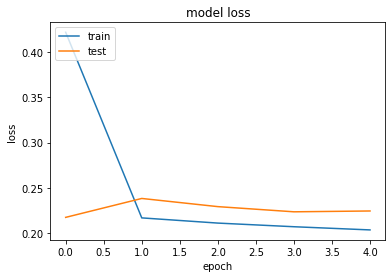

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


In [ ]:
# load the recipe dataset
recipe_df = pd.read_csv(data_path +'RAW_recipes.csv')

In [ ]:
#checking columns of recipe dataset
recipe_df.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')

In [ ]:
#rename the column id
recipe_df = recipes.rename(columns={"id":"recipe_id"})

In [ ]:
#checking columns of recipe dataset to make sure it's renamed
recipe_df.columns

Index(['name', 'recipe_id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')

In [ ]:
#Show top 10 recipe recommendations to a user

# Let us get a user and see the top recommendations.
user_id = df.user_id.sample(1).iloc[0]
recipes_cooked_by_user = df[df.user_id == user_id]
recipes_not_cooked = recipe_df[
    ~recipe_df["recipe_id"].isin(recipes_cooked_by_user.recipe_id.values)
]["recipe_id"]
recipes_not_cooked = list(
    set(recipes_not_cooked).intersection(set(recipe2recipe_encoded.keys()))
)
recipes_not_cooked = [[recipe2recipe_encoded.get(x)] for x in recipes_not_cooked]
user_encoder = user2user_encoded.get(user_id)
user_recipe_array = np.hstack(
    ([[user_encoder]] * len(recipes_not_cooked), recipes_not_cooked)
)
ratings = model.predict(user_recipe_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_recipe_ids = [
    recipe_encoded2recipe.get(recipes_not_cooked[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Recipes with high ratings from user")
print("----" * 8)
top_recipes_user = (
    recipes_cooked_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .recipe_id.values
)
recipe_df_rows = recipe_df[recipe_df["recipe_id"].isin(top_recipes_user)]
for row in recipe_df_rows.itertuples():
    print(row.name, ":", row.ingredients)

print("----" * 8)
print("Top 10 recipe recommendations")
print("----" * 8)
recommended_recipes = recipe_df[recipe_df["recipe_id"].isin(recommended_recipe_ids)]
for row in recommended_recipes.itertuples():
    print(row.name, ":", row.ingredients)


120/120 [==============================] - 0s 1ms/step
Showing recommendations for user: 176615
Recipes with high ratings from user
--------------------------------
blue and red berry smoothie : ['oatmeal', 'non-fat vanilla yogurt', 'orange juice', 'frozen blueberries', 'frozen strawberries']
marinated  grilled new york strip steaks : ['olive oil', 'worcestershire sauce', 'garlic cloves', "mccormick's montreal brand steak seasoning", 'red wine vinegar', 'dried basil', 'italian seasoning', 'new york strip steaks']
nutty cran feta salad : ['romaine lettuce', 'dried cranberries', 'red onion', 'pecans', 'feta cheese', 'raspberry vinegar', 'dijon mustard', 'sugar', 'salt', 'pepper', 'olive oil']
really really good candied sweet potatoes : ['sweet potatoes', 'butter', 'maple syrup', 'brown sugar', 'cinnamon']
substitute for 1 envelope onion soup mix : ['dried onion flakes', 'low-sodium beef bouillon granules', 'onion powder', 'parsley flakes', 'celery seed', 'paprika', 'pepper']
------------

## Create API

API workflow:

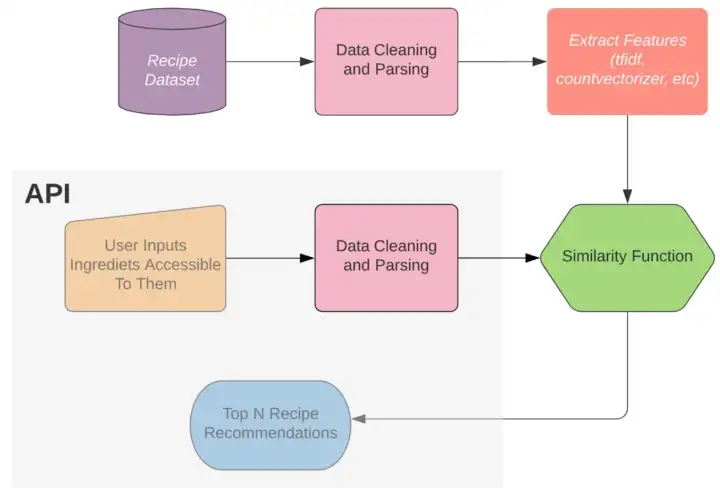

Image credit to https://towardsdatascience.com/building-a-recipe-recommendation-system-297c229dda7b

### Preprocessing and Parsing of Ingredients
NLTK https://www.nltk.org/
test NTLK to clean up junk words from the recipes and ingredient

In [ ]:
import nltk
vocabulary = nltk.FreqDist()
# This was done once preprocessed the ingredients
for ingredients in recipe_df['ingredients']:
    ingredients = ingredients.split()
    vocabulary.update(ingredients)
for word, frequency in vocabulary.most_common(200):
    print(f'{word};{frequency}')

In [ ]:
def ingredient_parser(ingredients):
    # measures and common words (already lemmatized)   
    measures = ['teaspoon', 't', 'tsp.', 'tablespoon', 'T', ...]
    words_to_remove = ['fresh', 'oil', 'a', 'red', 'bunch', ...]
    # Turn ingredient list from string into a list 
    if isinstance(ingredients, list):
       ingredients = ingredients
    else:
       ingredients = ast.literal_eval(ingredients)
    # first get rid of all the punctuation
    translator = str.maketrans('', '', string.punctuation)
    # initialize nltk's lemmatizer    
    lemmatizer = WordNetLemmatizer()
ingred_list = []
    for i in ingredients:
        i.translate(translator)
        # split up with hyphens as well as spaces
        items = re.split(' |-', i)
        # Get rid of words containing non alphabet letters
        items = [word for word in items if word.isalpha()]
        # Turn everything to lowercase
        items = [word.lower() for word in items]
        # remove accents
        items = [unidecode.unidecode(word) for word in items]
        # Lemmatize words so we can compare words to measuring words
        items = [lemmatizer.lemmatize(word) for word in items]
        # get rid of stop words
        stop_words = set(corpus.stopwords.words('english'))
        items = [word for word in items if word not in stop_words]
        # Gets rid of measuring words/phrases, e.g. heaped teaspoon
        items = [word for word in items if word not in measures]
        # Get rid of common easy words
        items = [word for word in items if word not in words_to_remove]
        if items:
           ingred_list.append(' '.join(items))
           ingred_list = ' '.join(ingred_list)
    return ingred_list

In [ ]:
recipe_df = pd.read_csv(config.RECIPES_PATH)
recipe_df['ingredients_parsed'] = recipe_df['ingredients'].apply(lambda x: ingredient_parser(x))
df = recipe_df.dropna()
df.to_csv(config.PARSED_PATH, index=False)

### Extracting Features

encode each document (recipe ingredients, One of the most basic models that should always be tried when doing NLP is bag of words. Scikit-learn’s CountVectorizer has a nice implementation for this. Bag of words performed ok but TF-IDF (term frequencies-inverse document frequency) marginally out-performed it. Scikit-learn has a lovely implementation of this: TfidfVectorizer

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import config
# load in parsed recipe dataset
df_recipes = pd.read_csv(config.PARSED_PATH)
# Tfidf needs unicode or string types
df_recipes['ingredients_parsed'] =       df_recipes.ingredients_parsed.values.astype('U')
# TF-IDF feature extractor
tfidf = TfidfVectorizer()
tfidf.fit(df_recipes['ingredients_parsed'])
tfidf_recipe = tfidf.transform(df_recipes['ingredients_parsed'])
# save the tfidf model and encodings
with open(config.TFIDF_MODEL_PATH, "wb") as f:
     pickle.dump(tfidf, f)
with open(config.TFIDF_ENCODING_PATH, "wb") as f:
     pickle.dump(tfidf_recipe, f)

### Recommendation System

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import config
from ingredient_parser import ingredient_parser
# load in tdidf model and encodings
with open(config.TFIDF_ENCODING_PATH, 'rb') as f:
     tfidf_encodings = pickle.load(f)
with open(config.TFIDF_MODEL_PATH, "rb") as f:
     tfidf = pickle.load(f)
# parse the ingredients using ingredient_parser
try:
    ingredients_parsed = ingredient_parser(ingredients)
except:
    ingredients_parsed = ingredient_parser([ingredients])
# use pretrained tfidf model to encode input ingredients
ingredients_tfidf = tfidf.transform([ingredients_parsed])
# calculate cosine similarity between actual recipe ingreds and test ingreds
cos_sim = map(lambda x: cosine_similarity(ingredients_tfidf, x), tfidf_encodings)
scores = list(cos_sim)

cosine similarity measures the cosine of the angle between two vectors.

In [ ]:
def get_recommendations(N, scores):
    # load in recipe dataset
    df_recipes = pd.read_csv(config.PARSED_PATH)
    # order the scores with and filter to get the highest N scores
    top = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:N]
    # create dataframe to load in recommendations
    recommendation = pd.DataFrame(columns = ['recipe', 'ingredients', 'score', 'url'])
    count = 0
    for i in top:
        recommendation.at[count, 'recipe'] = title_parser(df_recipes['recipe_name'][i])
        
        recommendation.at[count, 'ingredients'] = ingredient_parser_final(df_recipes['ingredients'][i])
        
        recommendation.at[count, 'url'] = df_recipes['recipe_urls'][i]
        recommendation.at[count, 'score'] = "{:.3f}".format(float(scores[i]))
        
        count += 1
    return recommendation

### Test Recommender

In [ ]:
!pip install -q tensorflow-recommenders 
!pip install -q --upgrade tensorflow-datasets

In [ ]:
from typing import Dict, Text
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [ ]:
!pip -q install scann

#### Load the data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

print('Loading data ...')
data_path = 'gs://'+bucket_id+'/'+folder_id+'/'
#//Load necessary data only
df_rrecipes=pd.read_csv(data_path +'RAW_recipes.csv')
df_itrain=pd.read_csv(data_path +'interactions_train.csv')
df_rinteraction=pd.read_csv(data_path +'RAW_interactions.csv')
print('Data Ready')

Loading data ...
Data Ready


In [ ]:
df_itrain.head()

In [ ]:
df_rrecipes.head(2)

name      id  minutes  \
0  arriba   baked winter squash mexican style  137739       55   
1            a bit different  breakfast pizza   31490       30   

   contributor_id   submitted  \
0           47892  2005-09-16   
1           26278  2002-06-17   

                                                tags  \
0  ['60-minutes-or-less', 'time-to-make', 'course...   
1  ['30-minutes-or-less', 'time-to-make', 'course...   

                                   nutrition  n_steps  \
0      [51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]       11   
1  [173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]        9   

                                               steps  \
0  ['make a choice and proceed with recipe', 'dep...   
1  ['preheat oven to 425 degrees f', 'press dough...   

                                         description  \
0  autumn is my favorite time of year to cook! th...   
1  this recipe calls for the crust to be prebaked...   

                                         ingredients  n_ingredients  
0  ['winter squash', 'mexican seasoning', 'mixed ...              7  
1  ['prepared pizza crust', 'sausage patty', 'egg...              6

In [ ]:
df_rinteraction.head()

In [ ]:
# Method 1 to import df to tf dataset
tf_itrain = tf.data.Dataset.from_tensor_slices(dict(df_itrain))
df_recipes=df_rrecipes[['id']]
tf_rrecipes = tf.data.Dataset.from_tensor_slices(dict(df_recipes))
tf_itrain

<TensorSliceDataset element_spec={'user_id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'recipe_id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'date': TensorSpec(shape=(), dtype=tf.string, name=None), 'rating': TensorSpec(shape=(), dtype=tf.float64, name=None), 'u': TensorSpec(shape=(), dtype=tf.int64, name=None), 'i': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [ ]:
len(tf_rrecipes)

231637

In [ ]:
def parse(filename):
    string = tf.strings.split([filename], sep=',').values
    return string

BATCH_SIZE = 32
dataset = tf.data.TextLineDataset(data_path +'RAW_interactions.csv').map(parse).batch(BATCH_SIZE)
# for i in dataset:
    # print(i)
dataset

<BatchDataset element_spec=TensorSpec(shape=(None, None), dtype=tf.string, name=None)>

In [ ]:
# Method 2 to import csv to tf dataset
data_path = 'gs://'+bucket_id+'/'+folder_id+'/'
tf_interactions = tf.data.experimental.make_csv_dataset(data_path +'RAW_interactions.csv',batch_size=32,label_name=None,num_epochs=10,shuffle=0,header=True)
tf_itrain = tf.data.experimental.make_csv_dataset(data_path +'interactions_train.csv',batch_size=32,label_name=None,num_epochs=10,shuffle=0,header=True)
tf_rrecipes = tf.data.experimental.make_csv_dataset(data_path + 'RAW_recipes.csv',batch_size=32,label_name=None,num_epochs=10,shuffle=0,header=True)
tf_interactions

<PrefetchDataset element_spec=OrderedDict([('user_id', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('recipe_id', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('date', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('rating', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('review', TensorSpec(shape=(None,), dtype=tf.string, name=None))])>

In [ ]:
rating = tf_itrain
recipes = tf_rrecipes

In [ ]:
import pprint #Data pretty printer: https://docs.python.org/3/library/pprint.html
def prettyprint(d):
  for x in d.take(1).as_numpy_iterator():
    pprint.pprint(x)

In [ ]:
prettyprint(rating)
rating

OrderedDict([('user_id',
              array([ 2046,  2046,  1773,  1773,  2046,  2046,  2312,  2312,  2312,
        2312,  2625,  2312,  2999,  2178,  2178,  3794,  3794,  3794,
        2312,  2695,  5523,  5523,  5523, 42189,  5929,  6164,  5523,
        6512,  6406,  6836,  3288,  6702], dtype=int32)),
             ('recipe_id',
              array([ 4684,   517,  7435,   278,  3431, 13307,   780, 51964,  1232,
        4397,   471,   164,  3567,  3704,  4366,  7508,   191,  3525,
        3651,   350,  2713,  7695,  1229,  4460,  7954,  1878,  7217,
        8092,  8486,  8566,  6819,  6852], dtype=int32)),
             ('date',
              array([b'2000-02-25', b'2000-02-25', b'2000-03-13', b'2000-03-13',
       b'2000-04-07', b'2000-05-21', b'2000-09-12', b'2000-09-26',
       b'2000-10-17', b'2000-10-17', b'2000-10-18', b'2000-10-20',
       b'2000-10-23', b'2000-10-30', b'2000-11-04', b'2000-12-11',
       b'2000-12-15', b'2000-12-15', b'2001-01-16', b'2001-01-19',
       b'2001

<PrefetchDataset element_spec=OrderedDict([('user_id', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('recipe_id', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('date', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('rating', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('u', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('i', TensorSpec(shape=(None,), dtype=tf.int32, name=None))])>

In [ ]:
recipes

<PrefetchDataset element_spec=OrderedDict([('name', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('id', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('minutes', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('contributor_id', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('submitted', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('tags', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('nutrition', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('n_steps', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('steps', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('description', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('ingredients', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('n_ingredients', TensorSpec(shape=(None,), dtype=tf.int32, name=None))])>

In [ ]:
df_rrecipes.head(1)

In [ ]:
df_itrain.head(1)

#### Retrieval

In [ ]:
# Select the basic features, We keep only the user_id, and movie_title fields in the dataset.
rating = rating.map(lambda x: {
    "recipe_id": x["recipe_id"],
    "user_id": x["user_id"]
})
recipes = recipes.map(lambda x: x["id"])

In [ ]:
rating

<MapDataset element_spec={'recipe_id': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'user_id': TensorSpec(shape=(None,), dtype=tf.int32, name=None)}>

In [ ]:
#use a random split, putting 80% of the ratings in the train set, and 20% in the test set.
tf.random.set_seed(42)
shuffled = rating.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [ ]:
recipes_ids = recipes.batch(1_000) #The underscores have no semantic meaning

In [ ]:
recipes_ids

In [ ]:
user_ids = rating.batch(1_000_000).map(lambda x: x["user_id"])

In [ ]:
# unique_recipes_ids = np.unique(np.concatenate(list(recipes_ids)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

In [ ]:
unique_recipes_ids[:20]

In [ ]:
unique_user_ids[:20]

#### Making predictions

In [ ]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index(movies.batch(100).map(model.movie_model), movies)

# Get recommendations.
_, titles = index(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :3]}")

## Deploy to Docker

In [ ]:
# Include where we get the image from (operating system)
FROM ubuntu:18.04
RUN apt-get update && apt-get install -y \
    git \
    curl \
    ca-certificates \
    python3 \
    python3-pip \
    sudo \
    && rm -rf /var/lib/apt/lists/*
# Set working directory
WORKDIR /app
# Copy everything in currect directory into the app directory.
ADD . /app
# Install all of the requirements
RUN pip3 install -r requirements.txt
# Download wordnet as its used to lemmatize
RUN python3 -c "import nltk; nltk.download('wordnet')"
# CMD executes once the container is started
CMD ["python3", "app.py"]

In [ ]:
docker build -f Dockerfile -t whatscooking:api

In [ ]:
docker run -p 5000:5000 -d whatscooking:api